In [1]:
!pip install folium --quiet

In [2]:
import pandas as pd
from pymongo import MongoClient

%matplotlib inline

mongo_client = MongoClient('18.236.138.158', 27016)
database_reference = mongo_client.twitter

| | | | | |
|-|-|-|-|-|
| `_id`        | `truncated`                 |`user`            |`extended_tweet` | `favorited`                   |
| `created_at` | `in_reply_to_status_id`     |`geo`             |`quote_count`    | `retweeted`                   |
| `id`         | `in_reply_to_status_id_str` |`coordinates`     |`reply_count`    | `filter_level`                |
| `id_str`     | `in_reply_to_user_id`       |`place`           |`retweet_count`  | `lang`                        |
| `text`       | `in_reply_to_user_id_str`   |`contributors`    |`favorite_count` | `timestamp_ms`                |
| `source`     | `in_reply_to_screen_name`   |`is_quote_status` |`entities`       |                               |
























![](https://www.evernote.com/l/AAEO7gpKcKdI5YJeGrni4GhdlBiBWdTa3YgB/image.png)

In [3]:
collection_reference = database_reference.instructor_test_group

In [4]:
collection_reference.count()

20000

In [5]:
from mongo_aggregation_verbs import *

## Tweets By Day

In [6]:
datestring_created_at = { "dateString" : "$created_at"}
date_from_string = {"$dateFromString" : datestring_created_at }

date_to_id = {
    PROJECT : {
        "_id" : 0,
        "year"  : {"$year"       : {"date" : date_from_string}},
        "month" : {"$month"      : {"date" : date_from_string}},
        "day"   : {"$dayOfMonth" : {"date" : date_from_string}},
    }
}

group_by_date = {
    GROUP : {
        "tweets" : { "$sum" : 1 }, #summing up tweets. 
        "_id" : {
            "year"  : "$year",
            "month" : "$month",
            "day"   : "$day"
        },
    }
}



In [7]:
def dictionary_to_datestring(x):
    month = x['month']
    day   = x['day']
    year  = x['year']
    return "{}-{}-{}".format(month, day, year)

In [8]:
cursor = collection_reference.aggregate([
    date_to_id,
    group_by_date
])

daily_tweets = pd.DataFrame(list(cursor))

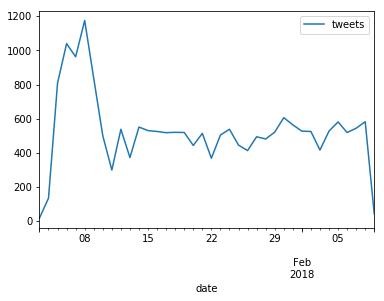

In [9]:
datestrings = daily_tweets['_id'].apply(dictionary_to_datestring)
daily_tweets['date'] = pd.to_datetime(datestrings)

daily_tweets.drop('_id', axis=1, inplace=True)
daily_tweets.sort_values('date', inplace=True)
daily_tweets.set_index('date', inplace=True)
daily_tweets.plot()

## Tweet Locations

In [10]:
not_null = { '$ne' : None }
nonnull_geo = {'geo' : not_null }
keep_geo = { 'geo' : 1 }

cursor = collection_reference.find(nonnull_geo, keep_geo) #find(1st argument is what you want to pass, 2 is what you want to keep)
cursor.count()

2952

In [11]:
geo_tweets = pd.DataFrame(list(cursor))

In [16]:
geo_tweets.head(5)["geo"].values # can't split, it is an object. they are dictionary. 

array([{'type': 'Point', 'coordinates': [34.18016221, -118.60321147]},
       {'type': 'Point', 'coordinates': [33.98752, -118.4538]},
       {'type': 'Point', 'coordinates': [34.1517492, -118.5214282]},
       {'type': 'Point', 'coordinates': [34.6495, -120.07927]},
       {'type': 'Point', 'coordinates': [33.9275, -118.27722]}], dtype=object)

In [17]:
def parse_geo_from_tweets(tweets):
    geo = pd.DataFrame(list(tweets['geo'].values))
    return geo

In [18]:
geo = parse_geo_from_tweets(geo_tweets)
geo.sample(5)

,coordinates,type
2169,"[36.778261, -119.4179324]",Point
1693,"[34.06143, -118.35405]",Point
1885,"[34.1489719, -118.451357]",Point
909,"[34.0522342, -118.2436849]",Point
1826,"[34.0221, -118.481]",Point


In [23]:
import folium
starting_loc = [34.0689, -118.4452]
la_map = folium.Map(location=starting_loc, zoom_start=13)

In [24]:
for loc in geo.coordinates.values:
    folium.Marker(loc).add_to(la_map)

In [25]:
la_map